# Gaussian Process Class Design

In [1315]:
%matplotlib inline
import numpy as np
import time
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.utilities import set_trainable
from IPython.display import clear_output
from tensorflow_probability import distributions as tfd
import json
# for reproducibility of this notebook:
tf.random.set_seed(42)
np.random.seed(42)

## Step 1: Prototype model
We implement a simple 1D model and define a periodic latent function which takes inputs X and returns outputs Y. Our training data is a noisy sample of the true function. Here the data is returned by a function but in reality this would be an endpoint. See notes at end for further thoughts on datasets.

In [1114]:
def true_f(X_input):
    return (3 * np.cos(5 * np.pi * X_input + 1*np.pi)) 

In [1266]:
def get_data():
    N_train = 5000
    N_test = 1250
    max_X = 2
    Xtrain = np.sort(max_X*np.random.rand(N_train))[:, None]  
    Ytrain = np.random.normal(true_f(Xtrain),scale=1.3)
    
    Xtest = np.sort(np.linspace(0, max_X, N_test))[:, None]  
    Ytest = true_f(Xtest)
    
    return (Xtrain, Ytrain), (Xtest, Ytest)

We can plot our data and the latent function

Text(0.5, 1.0, 'True f(X)')

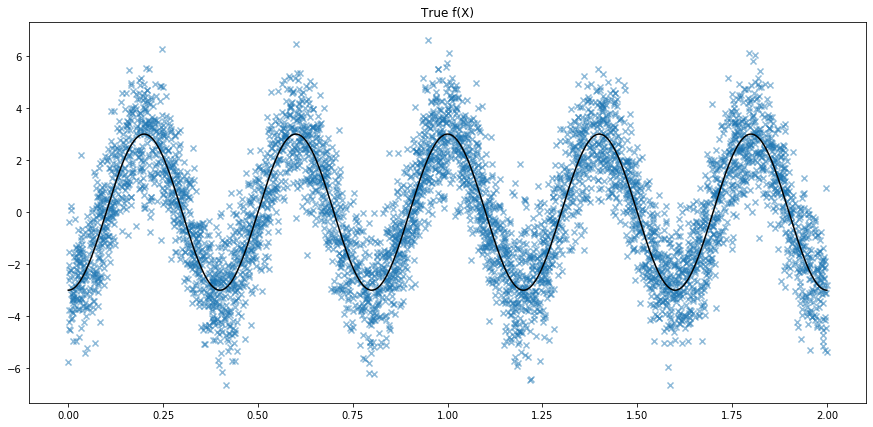

In [1267]:
train_data, test_data = get_data()

plt.figure(figsize=(15,7))
plt.scatter(train_data[0], train_data[1], alpha=0.5,marker="x")
Xt = np.linspace(0, max_X, N)[:, None]
Yt = true_f(Xt)
_ = plt.plot(Xt, Yt, c="k")
plt.title("True f(X)")

We define a Sparse Variational Gaussian Process, which requires a user-input kernel, likelihood and an array of inducing points. We use 15 inducing points here, but when pushing to production we would need to test our results with different values. We use a periodic kernel and guassian likelihood and space our inducing points evenly over the domain initially.

In [1426]:
def get_model():
    Z = np.linspace(0,2,15)[:,None]
    
    kernel = (gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF()) *
              gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF())
             )
    model = gpflow.models.SVGP(kernel=gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF())+gpflow.kernels.Bias(), 
                               inducing_variable=Z, 
                               likelihood = gpflow.likelihoods.Gaussian())
    return model

## Step 2: Define Trainer class

I've defined a seperate Trainer class which takes the model and dataset and iterates over a training step to optimize the model. I've tried to use as few gpflow abstractions as possible (e.g. defining own KL and elbo functions rather than using inbuilt) so that the code is more customisable in the long run. In my tests, using optimizer.minmize is quicker than the gradient tape method. I also fix the inducing points to start but optimize them every 200 steps, this provides a good trade off of prediction accuracy and training speed.

In [1431]:
class Trainer():
    '''Trainer class for GPFlow SVGP model'''
    
    def __init__(self, 
                 model, 
                 data, 
                 optimizer=tf.optimizers.Adam()):
        '''
        Initialise trainer class
        
        arguments:
        model - GPFlow SVGP model
        data - tuple, (X,Y) where X are observed input and Y are observed outputs
        optimizer - optional, tf.optimizer object, default is adam
        '''
        
        self.model = model
        self.data = data
        self.model_optimizer = optimizer   
   
    def get_KL(self):
        '''
        Compare KL divergence between prior and posterior distributions
        
        return:
        KL - Tensor of KL divergence 
        '''
        
        #get cholesky decomposition of covariance matrix conditioned on inducing points
        Z = self.model.inducing_variable.Z
        K = self.model.kernel(Z)
        K = tf.linalg.cholesky(K+0.005*tf.eye(K.shape[0], dtype='float64'))
        #calculate KL divergence
        pu = tfd.MultivariateNormalTriL(scale_tril=K)
        qu = tfd.MultivariateNormalTriL(self.model.q_mu[:,0],self.model.q_sqrt)        
        KL = tfd.kl_divergence(qu,pu)

        return KL
      
    def elbo(self):
        '''
        Get Evidence Based Lower Bound (ELBO) for training data
        
        return:
        elbo - Tensor of ELBO for model given (X,Y)
        '''
    
        X, Y = self.data
        kl = self.get_KL()
      
        #predict Ypred for given X
        f_mean, f_var = self.model.predict_f(X)
        #get variational expectation for Ypred given Y
        var_exp = self.model.likelihood.variational_expectations(f_mean, f_var, Y)       
        var_exp = tf.reduce_sum(var_exp)        
        #compute elbo, return negative ELBO to minimize
        elbo = var_exp - kl
        elbo = -1*elbo

        return elbo
    
    @tf.function
    def optimization_step(self):
        '''
        Calculate gradients and optimize model, uses tf.function to pass function as a graph
        
        return:
        loss - Tensor of ELBO for model given (X,Y)
        '''
        
        #disables training of inducing points
        
        #optimize hyperparameters given model loss for this training step
        self.model_optimizer.minimize(self.elbo, self.model.trainable_variables)
        loss = -1*self.elbo()
        
        return loss
        
    def train_model(self, iterations, with_output=True):
        '''
        Train model and log model losses
        
        arguments:
        iterations - number of training iterations, the optimization step is called once per iteration
        with_output - optional, if True will print information at each logging step
        
        returns:
        model_loss - returns np array of size 
        '''
        
        #initialise array to log model losses
        self.model_loss = np.array([])
        #fix inducing points
        set_trainable(self.model.inducing_variable, False)
        #loop optimization step and log losses, if with_output is true, record time and pass to logging func        
        if with_output:
            tic = time.perf_counter()        
        for step in range(iterations):
            #train inducing locations every 200 steps
            if step % 200 == 0:
                set_trainable(self.model.inducing_variable, True)
                loss = self.optimization_step()
                set_trainable(self.model.inducing_variable, False)
            else:
                loss = self.optimization_step()
            #log losses every 100 iterations, pass time and step information if with_output is True
            if step % 100 == 0:
                if with_output:
                    toc = time.perf_counter()
                    self._log(step, loss, tic, toc, iterations)
                else:
                    self._log(step, loss)
        #log final loss values
        if with_output:
            self._log((step+1), loss, tic, toc, iterations)
        else:
            self._log((step+1), loss)
        #reshape array into expected output
        model_loss = self.model_loss.reshape(-1,2)
        
        return model_loss
                
    def _log(self, step, loss, *args):
        '''
        Log model losses and print outputs if passed additional arguments
        
        arguments:
        step - the current training iteration
        loss - model loss at current iteration
        *tic - optional, time at training start
        *toc - optional, time at current iteration
        *iterations - optional, maximum iterations for given loop
        '''      
        
        #initialise logging parameters if passed
        if args:
            tic, toc, iterations = args
        #for intial timestep, log loss and optionally print output 
        if step == 0:            
            self.model_loss = np.append(self.model_loss, [step, loss.numpy().item()])
            if args:
                print("Starting training")
        #for each call, log the current model loss and optionally print output
        else:
            self.model_loss = np.append(self.model_loss, [step, loss.numpy().item()])
            if args:
                elapsed = toc-tic
                periter = elapsed/step            
                clear_output(wait=True)  
                print("Iteration {}/{}, elapsed time: {:.2f} seconds, time per iteration: {:.3f} seconds".format(step, 
                                                                                                             iterations, 
                                                                                                             elapsed, 
                                                                                                             periter))        

Now we can build the SVGP model, pass it to the trainer with the data and train, you can use more iterations if you wish, this is just for speed. On my machine, this is quicker on the CPU than on the GPU

In [1432]:
model=get_model()
trainer = Trainer(model,train_data)
with tf.device('/CPU:0'):
    loss = trainer.train_model(2500)

Iteration 2500/2500, elapsed time: 17.71 seconds, time per iteration: 0.007 seconds


We can plot our predicted Xtest results vs the latent function, notice that the inducing points have moved.

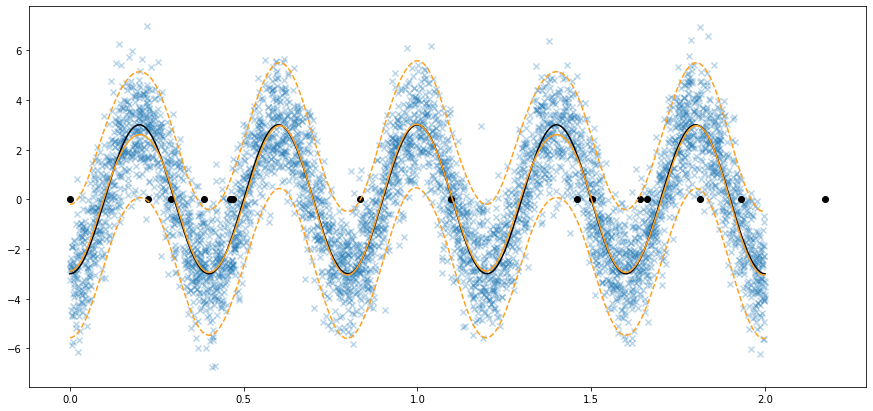

In [1433]:
Xtest, Ytrue = test_data
Ypred, Yvar = model.predict_y(Xtest)
Z = model.inducing_variable.Z.numpy()

plt.figure(figsize=(15,7))
plt.plot(Xtest, Ytrue, c='k')
plt.plot(Xtest, Ypred,c="#ffa01f")
plt.plot(Xtest,(Ypred - 2 * Yvar ** 0.5),c="#ffa01f", linestyle='--')
plt.plot(Xtest,(Ypred + 2 * Yvar ** 0.5), c="#ffa01f", linestyle='--')
plt.scatter(X,Y, alpha=0.3,marker="x")
plt.scatter(Z, np.zeros_like(Z), c='k')

In [1434]:
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse(Ytrue,Ypred).numpy()

0.13685638

Not bad, would be better if run for more iterations or if inducing points are optimized more often

## Step 3: Define Model Class

Here we inherit from the SGVP class and our trainer to produce a simple class which can be run in a container or further broken out in to microservices. Again, get_train_data() would pull down from an API end point in reality. 

We initialise our model as before in the init function. To train our model we load the dataset, pass it to the trainer and return the logs which would be saved to disk for comparison with past models, I also expect there would be a validation step here when we're pushing to production.

Once trained, our train function saves the model parameters as a json file. We can then load these parameters in our predict function.

In [1409]:
class ExampleGP(gpflow.models.SVGP, Trainer):
    
    def __init__(self):
        
        Z = np.linspace(0,2,15)[:,None]

        kernel = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.RBF())+gpflow.kernels.Bias()
        
        super().__init__(
                        kernel=kernel,
                        inducing_variable=Z, 
                        likelihood = gpflow.likelihoods.Gaussian()
                        )
        
    def get_train_data(self):
        return get_data()
    
    def train(self, iterations):
        train_data, _ = self.get_train_data()
        trainer = Trainer(model=self, data=train_data)
        logs = trainer.train_model(iterations)
        self.save_params()
        return logs
    
    def predict(self, X):
        trained_params = self.load_params()
        gpflow.utilities.multiple_assign(self, trained_params)
        Ypred, Yvar = self.predict_y(X)
        return Ypred, Yvar
    
    def save_params(self):
        trained_params = gpflow.utilities.parameter_dict(self)
        for key in trained_params.keys():
            trained_params[key] = trained_params[key].numpy().tolist()
        with open('trained_params.json', 'w') as fp:
            json.dump(trained_params, fp)
    
    def load_params(self):
        with open('trained_params.json', 'r') as fp:
            trained_params = json.load(fp)
        return trained_params

## Step 4: Define Endpoints:

Endpoints are pretty simple for the model and could easily be wrapped with Flask and used with docker. 

train() creates a new model and calls the train method from our ExampleGP class, this function builds the dataset, trains the model and saves the trained parameters for use by the predict function. In production we could call this with a cron job.

In [1441]:
def train():
    model = ExampleGP()
    logs = model.train(2500)
    # SAVE LOGS TO DISK FOR VALIDATION ETC. IN PRODUCTION
    
def predict(request):
    model = ExampleGP()
    response = model.predict(request)
    # RETURNING Z FOR PLOTS
    return response, model.inducing_variable.Z.numpy()

We can call these endpoints to train and predict as before

In [1437]:
with tf.device('/CPU:0'):
    loss = train()
Xtest, Ytrue = test_data
(Ypred, Yvar), Z = predict(Xtest)

Iteration 2500/2500, elapsed time: 12.44 seconds, time per iteration: 0.005 seconds


5 seconds faster than the previous example! The power of OOP or have I made a mistake, let me know if you spot one!

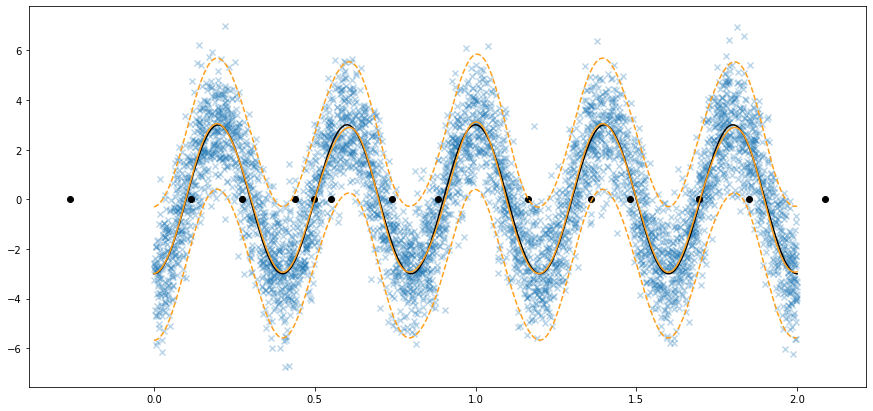

In [1438]:
plt.figure(figsize=(15,7))
plt.plot(Xtest, Ytrue, c='k')
plt.plot(Xtest, Ypred,c="#ffa01f")
plt.plot(Xtest,(Ypred - 2 * Yvar ** 0.5),c="#ffa01f", linestyle='--')
plt.plot(Xtest,(Ypred + 2 * Yvar ** 0.5), c="#ffa01f", linestyle='--')
plt.scatter(X,Y, alpha=0.3,marker="x")
plt.scatter(Z, np.zeros_like(Z), c='k')

In [1440]:
rmse(Ytrue, Ypred).numpy()

0.1200312

Slightly better RMSE, though this would probably even out over multiple runs.